# Objective Functions: A Simple Example with Matrix Factorisation.

### 6th October 2015 Neil D. Lawrence

### Modified by Mauricio A Álvarez, 1st October 2018

In last week's class we saw how we could load in a data set to pandas and use it for some simple data processing. We computed various probabilities on the data and I encouraged you to think about what sort of probabilities you need for prediction. This week we are going to take a slightly different tack. 

Broadly speaking there are two dominating approaches to machine learning problems. We started to consider the first approach last week: constructing models based on defining the relationship between variables using probabilities. This week we will consider the second approach: which involves defining an *objective function* and optimizing it. 

What do we mean by an objective function? An objective function could be an *error function*, a *cost function* or a *benefit* function. In evolutionary computing they are called *fitness* functions. But the idea is always the same. We write down a mathematical equation which is then optimized to do the learning. The equation should be a function of the *data* and our model *parameters*. We have a choice when optimizing, either minimize or maximize. To avoid confusion, in the optimization field, we always choose to minimize the function. If we have a function that we would like to maximize, we simply choose to minimize the negative of that function. 

So for this lab session, we are going to ignore probabilities, but don't worry, they will return! 

This week we are going to try and build a simple movie recommender system using an objective function. To do this, the first thing I'd like you to do is to install some software we've written for sharing information across google documents.

## Open Data Science Software

In Sheffield we have written a suite of software tools for 'Open Data Science'. Open data science is an approach to sharing code, models and data that should make it easier for companies, health professionals and scientists to gain access to data science techniques. For some background on open data science you can read [this blog post](http://inverseprobability.com/2014/07/01/open-data-science/). The first thing we will do this week is to download that suite of software. 

The software can be installed using

```python
pip install pods
```

from the command prompt where you can access your python installation.


## Download the MovieLens 100k Data

We are going to download the [MovieLens 100k](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) Data. This is a public dataset that contains 100,000 ratings and 3,600 tag applications applied to 9,000 movies by 600 users. When you use a data set that someone has prepared you should always reference the data source to acknowledge the work that's been placed in. This particular dataset was collected by the [Grouplens Research group](https://grouplens.org/),  at the University of Minnesota. For example, if you were to use this dataset for writing a paper, the authors ask you that you acknowledge their work by citing the following paper:

F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5 (4):1-19 [https://doi.org/10.1145/2827872](https://doi.org/10.1145/2827872)

In [3]:
import pods
import zipfile
import sys
import pandas as pd
import numpy as np

pods.util.download_url("http://files.grouplens.org/datasets/movielens/ml-latest-small.zip")
zip_console = zipfile.ZipFile('ml-latest-small.zip', 'r')
for name in zip_console.namelist():
           zip_console.extract(name, './')

[==============================]   0.933/0.933MB                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

### Assignment Question 1

Data ethics. If you find data available on the internet, can you simply use it without consequence? If you are given data by a fellow researcher can you publish that data on line? 

*5 marks*

#### Question 1 Answer

(1)No.I should use these data directly.I need to check the relative permission.
(2)No.I should ask for permission first and label the reference information.

## Recommender Systems

A recommender system aims to make suggestions for items (films, books, other commercial products) given what it knows about users' tastes. The recommendation engine needs to represent the *taste* of all the users and the *characteristics* of each object. 

A common way for organizing objects is to place related objects spatially close together. For example in a library we try and put books that are on related topics near to each other on the shelves. One system for doing this is known as [Dewey Decimal Classification](http://en.wikipedia.org/wiki/Dewey_Decimal_Classification). In the Dewey Decimal Classification system (which dates from 1876) each subject is given a number (in fact it's a decimal number). For example, the field of Natural Sciences and Mathematics is given numbers which start with 500. Subjects based on Computer Science are given numbers which start 004 and works on the 'mathematical principles' of Computer science are given the series 004.0151 (which we might store as 4.0151 on a Computer). Whilst it's a classification system, the books in the library are typically laid out in the same order as the numbers, so we might expect that neighbouring numbers represent books that are related in subject. That seems to be exactly what we want when also representing films. Could we somehow represent each film's subject according to a number? In a similar way we could then imagine representing users with a list of numbers that represent things that each user is interested in.

Actually a one dimensional representation of a subject can be very awkward. To see this, let's have a look at the Dewey Decimal Classification numbers for the 900s, which is listed as 'History and Geography'. We will focus on subjects in the 940s which can be found in this list from [Wikipedia](https://en.wikipedia.org/wiki/List_of_Dewey_Decimal_classes#Class_900_%E2%80%93_History_&_geography). Whilst the ordering for places is somewhat sensible, it is also rather arbitrary. In the 940s we have Europe listed from 940-949, Asia listed from 950-959 and Africa listed from 960-969. Whilst it's true that Asia borders Europe, Africa is also very close, and the history of the Roman Empire spreads into [Carthage](http://en.wikipedia.org/wiki/Carthage) and later on Egypt. This image from Wikipedia shows a map of the Cathaginian Empire which fell after fighting with Rome. 


<a title="By Javierfv1212 [Public domain], from Wikimedia Commons" href="https://commons.wikimedia.org/wiki/File:Carthaginianempire.PNG"><img width="512" alt="Carthaginianempire" src="https://upload.wikimedia.org/wikipedia/commons/thumb/9/9b/Carthaginianempire.PNG/512px-Carthaginianempire.PNG"></a>

We now need to make a decision about whether Roman Histories are European or African, ideally we'd like them to be somewhere between the two, but we can't place them there in the Dewey Decimal system because between Europe and Africa is Asia, which has less to do with the Roman Empire than either Europe or Africa. Of course the fact that we've used a map provides a clue as to what to do next. Libraries are actually laid out on floors, so what if we were to use the spatial lay out to organise the sujbects of the books in two dimensions. Books on Geography could be laid out according to where in the world they are referring to. 

Such complexities are very hard to encapsulate in one number, but inspired by the map examples we can start considering how we might lay out films in two dimensions. Similarly, we can consider laying out a map of people's interests. If the two maps correspond to one another, the map of people could reflect where they might want to live in 'subject space'. We can think of representing people's tastes as where they might best like to sit in the library to access easily the books they are most interested in.


## Inner Products for Representing Similarity

Ideas like the above are good for gaining intuitions about what we might want, but the one of the skills of data science is representing those ideas mathematically. Mathematical abstraction of a problem is one of the key ways in which we've been able to progress as a society. Understanding planetary motions, as well as those of the smallest molecule (to quote Laplace's [Philosophical Essay on Probabilities](http://books.google.co.uk/books?id=1YQPAAAAQAAJ&printsec=frontcover&source=gbs_ge_summary_r&cad=0#v=onepage&q&f=false)) needed to be done mathematically. The right mathematical model in machine learning can be slightly more elusive, because constructing it is a two stage process. 

1. We have to determine the right intuition for the system we want to represent. Notions such as 'subject' and 'interest' are not mathematically well defined, and even when we create a new interpretation of what they might mean, each interpretation may have its own weaknesses. 

2. Once we have our interpretation we can attempt to mathematically formalize it. In our library interpretation, that's what we need to do next. 

### The Library on an Infinite Plane

Let's imagine a library which stores all the items  we are interested in, not just books, but films and shopping items too. Such a library is likely to be very large, so we'll create it on an infinite two dimensional plane. This means we can use all the real numbers to represent the location of each item on the plane. For a two dimensional plane, we need to store the locations in a vector of numbers: we can decide that the $j$th item's location in the library is given by 
$$
\mathbf{v}_j = \begin{bmatrix} v_{j,1} \\ v_{j,2}\end{bmatrix},
$$
where $v_{j,1}$ represents the $j$th item's location in the East-West direction (or the $x$-axis) and $v_{j,2}$ represents the $j$th item's location in the North-South direction (or the $y$-axis). Now we need to specify the location where each user sits so that all the items that interest them are nearby: we can also represent the $i$th user's location with a vector 
$$
\mathbf{u}_i = \begin{bmatrix} u_{i,1} \\ u_{i,2}\end{bmatrix}.
$$
Finally, we need some way of recording a given user's affinity for a given item. This affinity might be the rating that the user gives the film. We can use $y_{i,j}$ to represent user $i$'s affinity for item $j$. 

For our film example we might imagine wanting to order films in a few ways. We could imagine organising films in the North-South direction as to how romantic they are. We could place the more romantic films further North and the less romantic films further South. For the East-West direction we could imagine ordering them according to how historic they are: we can imagine placing science fiction films to the East and historical drama to the West. In this case, fans of historical romances would be based in the North-West location, whilst fans of Science Fiction Action films might be located in the South-East (if we assume that 'Action' is the opposite of 'Romance', which is not necessarily the case). How do we lay out all these films? Have we got the right axes? In machine learning the answer is to 'let the data speak'. Use the data to try and obtain such a lay out. To do this we first need to obtain the data.

## Obtaining the Data

As mentioned before, the MovieLens dataset that we'll use has 100,000 ratings to 9,000 movies by 600 users. For now, we will only work with a subset of the dataset. In particular, we will randomly chose a particular number of users and extract the movies and ratings that the users gave to those movies. Read the code below and understand what it is doing.

**Before you run the code**, notice that `YourStudentID` in the first line is a variable that will specify the seed for the random number generator that will select a particular set of `nUsersInExample` users. Change the number that has been assigned by default to `YourStudentID` to the last three digits of your UCard number. All of you will have a different subset of users.

In [4]:
YourStudentID = 848  # Include here the last three digits of your UCard number
nUsersInExample = 10 # The maximum number of Users we're going to analyse at one time

ratings = pd.read_csv("./ml-latest-small/ratings.csv") 
"""
ratings is a DataFrame with four columns: userId, movieId, rating and tags. We
first want to identify how many unique users there are. We can use the unique 
method in pandas
"""
indexes_unique_users = ratings['userId'].unique()
n_users = indexes_unique_users.shape[0]
""" 
We randomly select 'nUsers' users with their ratings. We first fix the seed
of the random generator to make sure that we always get the same 'nUsers'
"""
np.random.seed(YourStudentID)
indexes_users = np.random.permutation(n_users)
my_batch_users = indexes_users[0:nUsersInExample]

"""
We will use now the list of 'my_batch_users' to create a matrix Y. 
"""
# We need to make a list of the movies that these users have watched
list_movies_each_user = [[] for _ in range(nUsersInExample)]
list_ratings_each_user = [[] for _ in range(nUsersInExample)]

# Movies
list_movies = ratings['movieId'][ratings['userId'] == my_batch_users[0]].values
list_movies_each_user[0] = list_movies


# Ratings                      
list_ratings = ratings['rating'][ratings['userId'] == my_batch_users[0]].values
list_ratings_each_user[0] = list_ratings


# Users
n_each_user = list_movies.shape[0]
list_users = my_batch_users[0]*np.ones((1, n_each_user))


for i in range(1, nUsersInExample):
    # Movies
    local_list_per_user_movies = ratings['movieId'][ratings['userId'] == my_batch_users[i]].values
    list_movies_each_user[i] = local_list_per_user_movies
    list_movies = np.append(list_movies,local_list_per_user_movies)
    # Ratings                                 
    local_list_per_user_ratings = ratings['rating'][ratings['userId'] == my_batch_users[i]].values
    list_ratings_each_user[i] = local_list_per_user_ratings
    list_ratings = np.append(list_ratings, local_list_per_user_ratings)  
    # Users                                   
    n_each_user = local_list_per_user_movies.shape[0]                                                                               
    local_rep_user =  my_batch_users[i]*np.ones((1, n_each_user))    
    list_users = np.append(list_users, local_rep_user)

# Let us first see how many unique movies have been rated
indexes_unique_movies = np.unique(list_movies)
n_movies = indexes_unique_movies.shape[0]

# As it is expected no all users have rated all movies. We will build a matrix Y 
# with NaN inputs and fill according to the data for each user 
temp = np.empty((n_movies,nUsersInExample,))
temp[:] = np.nan
Y_with_NaNs = pd.DataFrame(temp)
for i in range(nUsersInExample):
 local_movies = list_movies_each_user[i]
 ixs = np.in1d(indexes_unique_movies, local_movies)
 Y_with_NaNs.loc[ixs, i] = list_ratings_each_user[i]

Y_with_NaNs.index = indexes_unique_movies.tolist()
Y_with_NaNs.columns = my_batch_users.tolist()




### Assignment Question 2

Have a look at the matrix `Y_with_NaNs`. The movies data is now in a data frame which contains one column for each user rating the movie. There are some entries that contain 'NaN'. What does the 'NaN' mean in this context?

*5 marks*

#### Answer Question 2

'NaN' means 'Not a Number'.It can be seen as an empty value in this matrix.

Now we will convert our data structure into a form that is appropriate for processing. We will convert the `Y_with_NaNs` dataframe into a new dataframe which contains the user, the movie, and the rating using the following code

In [5]:
p_list_ratings = np.concatenate(list_ratings_each_user).ravel()
p_list_ratings_original = p_list_ratings.tolist()
mean_ratings_train = np.mean(p_list_ratings)
p_list_ratings =  p_list_ratings - mean_ratings_train # remove the mean
p_list_movies = np.concatenate(list_movies_each_user).ravel().tolist()
p_list_users = list_users.tolist()
Y = pd.DataFrame({'users': p_list_users, 'movies': p_list_movies, 'ratingsorig': p_list_ratings_original,'ratings':p_list_ratings.tolist()})

#print(Y)

### Assignment Question 3

The dataframes `Y_with_NaNs` and `Y` contain the same information but organised in a different way. Explain what is the difference. We have also included two columns for ratings in dataframe `Y`, `ratingsorig` and `ratings`. Explain
the difference. 

*10 marks*

#### Question 3 Answer

(1)Y is an user-orientation array.It changes the users to show theirs ratings.
   However,Y_with_NaNs is an movie-orientation array.It shows who rates this movie.
(2)ratingsorig is the original rating mark.ratings equal the diff of the original rating and the mean rating.
 

## Measuring Similarity

We now need a measure for determining the similarity between the item and the user: how close the user is sitting to the item in the rooom if you like. We are going to use the inner product between the vector representing the item and the vector representing the user. 

An inner product (or [dot product](http://en.wikipedia.org/wiki/Dot_product)) between two vectors $\mathbf{a}$ and $\mathbf{b}$ is written as $\mathbf{a}\cdot\mathbf{b}$. Or in vector notation we sometimes write it as $\mathbf{a}^\top\mathbf{b}$. An inner product is simply the sume of the products of each element of the vector,
$$
\mathbf{a}^\top\mathbf{b} = \sum_{i} a_i b_i
$$
The inner product can be seen as a measure of similarity. The inner product gives us the cosine of the angle between the two vectors multiplied by their length. The smaller the angle between two vectors the larger the inner product. 
$$
\mathbf{a}^\top\mathbf{b} = |\mathbf{a}||\mathbf{b}| \cos(\theta)
$$
where $\theta$ is the angle between two vectors and $|\mathbf{a}|$ and $|\mathbf{b}|$ are the respective lengths of the two vectors.

Since we want each user to be sitting near each item, then we want the inner product to be large for any two items which are rated highly by that user. We can do this by trying to force the inner product $\mathbf{u}_i^\top\mathbf{v}_j$ to be similar to the rating given by the user, $y_{i,j}$. To ensure this we will use a least squares objective function for all user ratings.

## Objective Function

The error function (or objective function, or cost function) we will choose is known as 'sum of squares', we will aim to minimize the sum of squared squared error between the inner product of $\mathbf{u}_i$ and $\mathbf{v}_i$ and the observed score for the user/item pairing, given by $y_{i, j}$. 

The total objective function can be written as
$$
E(\mathbf{U}, \mathbf{V}) = \sum_{i,j} s_{i,j} (y_{i,j} - \mathbf{u}_i^\top \mathbf{v}_j)^2
$$
where $s_{i,j}$ is an *indicator* variable that is 1 if user $i$ has rated item $j$ and is zero otherwise. Here $\mathbf{U}$ is the matrix made up of all the vectors $\mathbf{u}$,
$$
\mathbf{U} = \begin{bmatrix} \mathbf{u}_1 \dots \mathbf{u}_n\end{bmatrix}^\top
$$
where we note that $i$th *row* of $\mathbf{U}$ contains the vector associated with the $i$th user and $n$ is the total number of users. This form of matrix is known as a *design matrix*. Similarly, we define the matrix
$$
\mathbf{V} = \begin{bmatrix} \mathbf{v}_1 \dots \mathbf{v}_m\end{bmatrix}^\top
$$
where again the $j$th row of $\mathbf{V}$ contains the vector associated with the $j$th item and $m$ is the total number of items in the data set.

## Objective Optimization

The idea is to mimimize this objective. A standard, simple, technique for minimizing an objective is *gradient descent* or *steepest descent*. In gradient descent we simply choose to update each parameter in the model by subtracting a multiple of the objective function's gradient with respect to the parameters. So for a parameter $u_{i,j}$ from the matrix $\mathbf{U}$ we would have an update as follows:
$$
u_{k,\ell} \leftarrow u_{k,\ell} - \eta \frac{\text{d} E(\mathbf{U}, \mathbf{V})}{\text{d}u_{k,\ell}} 
$$
where $\eta$ (which is pronounced *eta* in English) is a Greek letter representing the *learning rate*.  

We can compute the gradient of the objective function with respect to $u_{k,\ell}$ as
$$
\frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}u_{k,\ell}} = -2 \sum_j s_{k,j}v_{j,\ell}(y_{k, j} - \mathbf{u}_k^\top\mathbf{v}_{j}). 
$$
Similarly each parameter $v_{i,j}$ needs to be updated according to its gradient. 


### Assignment Question 4

What is the gradient of the objective function with respect to $v_{k, \ell}$? Write your answer in the box below, and explain which differentiation techniques you used to get there. You will be expected to justify your answer in class by oral questioning. 

*15 marks*

#### Question 4 Answer

$$
E(\mathbf{U}, \mathbf{V}) = \sum_{i,j} s_{i,j} (y_{i,j} - \mathbf{u}_i^\top \mathbf{v}_j)^2
$$
where $s_{i,j}$ is an *indicator* variable that is 1 if user $i$ has rated item $j$ and is zero otherwise.

 $\eta$ is the *learning rate*. 
 
For a parameter $v_{i,j}$ from the matrix $\mathbf{U}$ we would have an update as follows:
$$
v_{k,\ell} \leftarrow v_{k,\ell} - \eta \frac{\text{d} E(\mathbf{U}, \mathbf{V})}{\text{d}v_{k,\ell}} 
$$
 



We can compute the gradient of the objective function with respect to $v_{k,\ell}$ as
$$
\frac{\text{d}E(\mathbf{U}, \mathbf{V})}{\text{d}v_{k,\ell}} = -2 \sum_j s_{k,j}u_{k,\ell}(y_{k, j} - \mathbf{u}_k^\top\mathbf{v}_{j}). 
$$

## Steepest Descent Algorithm

In the steepest descent algorithm we aim to minimize the objective function by subtacting the gradient of the objective function from the parameters. 

### Initialisation

To start with though, we need initial values for the matrix $\mathbf{U}$ and the matrix $\mathbf{V}$. Let's create them as `pandas` data frames and initialise them randomly with small values.

In [6]:
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.01
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)
#print(U)

Now that we have the initial values set, we can start the optimization. First we define a function for the gradient of the objective and the objective function itself.

In [6]:
def objective_gradient(Y, U, V):
    gU = pd.DataFrame(np.zeros((U.shape)), index=U.index)
    gV = pd.DataFrame(np.zeros((V.shape)), index=V.index)
    obj = 0.
    nrows = Y.shape[0]
    for i in range(nrows):
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        diff = prediction - rating # vTu - y
        obj += diff*diff
        gU.loc[user] += 2*diff*V.loc[film]
        gV.loc[film] += 2*diff*U.loc[user]
    return obj, gU, gV

Now we can write our simple optimisation route. This allows us to observe the objective function as the optimization proceeds.

In [8]:
iterations = 20
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V)
    print("Iteration", i, "Objective function: ", obj)
    U -= learn_rate*gU
    V -= learn_rate*gV    

Iteration 0 Objective function:  1357.4869965133857
Iteration 1 Objective function:  1282.480028008098
Iteration 2 Objective function:  1165.9886521752292
Iteration 3 Objective function:  1032.0047316911441
Iteration 4 Objective function:  941.4160919931817
Iteration 5 Objective function:  909.8765126034931
Iteration 6 Objective function:  893.1168056116112
Iteration 7 Objective function:  870.1346997768964
Iteration 8 Objective function:  836.2130968928965
Iteration 9 Objective function:  788.1252283503303
Iteration 10 Objective function:  724.7043051070563
Iteration 11 Objective function:  649.5819546833078
Iteration 12 Objective function:  572.0253655898285
Iteration 13 Objective function:  502.12647978858723
Iteration 14 Objective function:  443.30081208032675
Iteration 15 Objective function:  391.72178940230106
Iteration 16 Objective function:  343.3169716918441
Iteration 17 Objective function:  299.0650102366332
Iteration 18 Objective function:  263.4208495298329
Iteration 19 Obj

### Assignment Question 5

What happens as you increase the number of iterations? What happens if you increase the learning rate?

*10 marks*

#### Question 5 Answer


(1)If we increase the number of iterations,the objective function will converge to zero.
(2)If we increase the learning rate, the objective function will change faster.However, we should not set up a very high learning rate because it might skip the right result.

In [11]:
# Question 5 Code Answer
q = 2 # the dimension of our map of the 'library'
learn_rate = 0.02
U = pd.DataFrame(np.random.normal(size=(nUsersInExample, q))*0.001, index=my_batch_users)
V = pd.DataFrame(np.random.normal(size=(n_movies, q))*0.001, index=indexes_unique_movies)

iterations = 40
for i in range(iterations):
    obj, gU, gV = objective_gradient(Y, U, V)
    print("Iteration", i, "Objective function: ", obj)
    U -= learn_rate*gU
    V -= learn_rate*gV  

Iteration 0 Objective function:  1440.4133101133127
Iteration 1 Objective function:  1440.4128727299621
Iteration 2 Objective function:  1440.4122640108528
Iteration 3 Objective function:  1440.4106025868866
Iteration 4 Objective function:  1440.405540820323
Iteration 5 Objective function:  1440.3892936263744
Iteration 6 Objective function:  1440.335284286783
Iteration 7 Objective function:  1440.151190864178
Iteration 8 Objective function:  1439.5124745661478
Iteration 9 Objective function:  1437.2707902312707
Iteration 10 Objective function:  1429.3732440841159
Iteration 11 Objective function:  1401.9190690699675
Iteration 12 Objective function:  1312.7603195109964
Iteration 13 Objective function:  1089.8305149819382
Iteration 14 Objective function:  871.5375505459616
Iteration 15 Objective function:  803.5639314935747
Iteration 16 Objective function:  698.2044420080701
Iteration 17 Objective function:  566.416056550537
Iteration 18 Objective function:  431.09797448656343
Iteration 1

## Making Predictions

Predictions can be made from the model of the appropriate rating for a given user, $i$, for a given film, $j$, by simply taking the inner product between their vectors $\mathbf{u}_i$ and $\mathbf{v}_j$. 

### Assignment Question 6

Create a function that provides the prediction of the ratings for the users in the dataset. Is the quality of the predictions affected by the number of iterations or the learning rate? The function should receive `Y`, `U` and `V` and return the predictions and the absolute error between the predictions and the actual rating given by the users. The predictions and the absolute error should be added as additional columns to the dataframe `Y`.

*15 marks*

In [7]:
# Question 6 Code Answer

def rating_prediction(Y, U, V):
 
    nrows = Y.shape[0]
    for i in range(nrows):
        row = Y.iloc[i]
        user = row['users']
        film = row['movies']
        rating = row['ratings']
        ratingorig = row['ratingsorig']
        
        prediction = np.dot(U.loc[user], V.loc[film]) # vTu
        
        diff = prediction - rating # vTu - y
        
    return prediction,diff


## Stochastic Gradient Descent or Robbins Monroe Algorithm

Stochastic gradient descent involves updating separating each gradient update according to each separate observation, rather than summing over them all. It is an approximate optimization method, but it has proven convergence under certain conditions and can be much faster in practice. It is used widely by internet companies for doing machine learning in practice. For example, Facebook's ad ranking algorithm uses stochastic gradient descent. 

### Assignment Question 7

Create a stochastic gradient descent version of the algorithm. Monitor the objective function after every 1000 updates to ensure that it is decreasing. When you have finished, plot the movie map and the user map in two dimensions (you can use the columns of the matrices $\mathbf{U}$ for the user map and the columns of $\mathbf{V}$ for the movie map). Provide three observations about these maps.

*25 marks*

In [17]:
# Question 7 Code Answer

import numpy as np
import pandas as pd
import sys
counter = 0

learn_rate = 0.01

for i in range(100):
    Y_random = Y.sample(frac = 1)        #random Y
    for ind, series in Y_random.iterrows():
        
        film = series['movies']
        user = series['users']
        rating = series['ratings']

        u = U.loc[user].values
        v = V.loc[film].values
        
        u += learn_rate * v * (rating-np.dot(u,v))
        v += learn_rate * u * (rating-np.dot(u,v))
        
        U.loc[user] = u
        V.loc[film] = v
        
        counter += 1

        if not counter % 1000: 
            obj = objective_gradient(Y, U, V)
            print ("Update:", counter, "Objective:", obj) 
            


Update: 1000 Objective: (1440.3965221369565,             0         1
552  0.007990  0.114917
293  0.014643  0.025108
9    0.008858  0.044349
25  -0.001557  0.038900
402  0.018799  0.060897
401  0.007891 -0.015057
389  0.030580  0.029882
418  0.233527  0.214292
542  0.189400  0.301021
232 -0.188869  0.600319,                0         1
1       0.002774  0.007241
2      -0.005787  0.016608
3       0.000144 -0.014017
5       0.001071 -0.000201
6       0.005025  0.005316
9      -0.001971 -0.003420
10      0.003093 -0.008876
17      0.001983  0.002097
19     -0.000009  0.000905
25      0.001093 -0.002280
32      0.001983  0.002097
36     -0.000911 -0.002299
39      0.003092 -0.008876
41     -0.000442 -0.001855
47      0.010110  0.059027
48      0.006656 -0.018891
50      0.018039  0.014157
52     -0.000911 -0.002299
61      0.004321  0.010900
62      0.005025  0.005316
65      0.001983  0.002097
95      0.003801 -0.004634
104     0.000657  0.003884
110    -0.010226  0.029350
111     0.01803

Update: 6000 Objective: (1440.3526773625058,             0         1
552  0.016848  0.200658
293  0.016117  0.032488
9    0.011670  0.065301
25  -0.005776  0.084798
402  0.023605  0.082428
401  0.008372 -0.015137
389  0.035618  0.037764
418  0.360720  0.362612
542  0.289348  0.483815
232 -0.402142  1.330224,                0         1
1       0.002855  0.013014
2      -0.011763  0.036049
3      -0.000600 -0.023887
5       0.001488 -0.000273
6       0.006621  0.006915
9      -0.002520 -0.004460
10      0.006287 -0.019267
17      0.002612  0.002728
19      0.000039  0.001543
25      0.001399 -0.003816
32      0.002612  0.002728
36     -0.001124 -0.003002
39      0.006286 -0.019264
41     -0.000545 -0.002390
47      0.010374  0.110448
48      0.014119 -0.043610
50      0.027430  0.023184
52     -0.001124 -0.003002
61      0.005330  0.014234
62      0.006621  0.006915
65      0.002612  0.002728
95      0.004243 -0.010457
104    -0.000214  0.007575
110    -0.020788  0.063708
111     0.02743

Update: 11000 Objective: (1440.207151644131,             0         1
552  0.037679  0.399184
293  0.018573  0.045939
9    0.016873  0.106780
25  -0.013604  0.177297
402  0.032771  0.123528
401  0.010143 -0.015842
389  0.044752  0.052095
418  0.594234  0.655966
542  0.443636  0.785153
232 -0.737565  2.589103,                0         1
1       0.002992  0.023048
2      -0.021410  0.069527
3      -0.002855 -0.049305
5       0.002134 -0.000516
6       0.009183  0.009771
9      -0.003426 -0.006432
10      0.011443 -0.037161
17      0.003623  0.003855
19      0.000184  0.003185
25      0.001710 -0.007829
32      0.003623  0.003855
36     -0.001490 -0.004372
39      0.011439 -0.037148
41     -0.000730 -0.003524
47      0.009789  0.196809
48      0.026202 -0.086371
50      0.045184  0.042694
52     -0.001490 -0.004372
61      0.007064  0.020731
62      0.009183  0.009772
65      0.003623  0.003855
95      0.004164 -0.026772
104    -0.001782  0.012722
110    -0.037837  0.122874
111     0.04518

Update: 16000 Objective: (1439.5922850703885,             0         1
552  0.068956  0.733759
293  0.016757  0.069939
9    0.017656  0.174082
25  -0.028705  0.383060
402  0.035093  0.198634
401  0.013016 -0.020624
389  0.052704  0.075388
418  0.970769  1.225236
542  0.759804  1.487292
232 -1.459599  5.365968,                0         1
1       0.000523  0.042980
2      -0.041462  0.144966
3      -0.006218 -0.085460
5       0.002719 -0.000913
6       0.011519  0.012771
9      -0.004256 -0.008645
10      0.022161 -0.077484
17      0.004545  0.005039
19      0.000402  0.005521
25      0.001796 -0.013588
32      0.004545  0.005039
36     -0.001826 -0.005952
39      0.022146 -0.077429
41     -0.000904 -0.004902
47      0.010638  0.395648
48      0.051901 -0.183995
50      0.073735  0.076099
52     -0.001827 -0.005952
61      0.008661  0.028224
62      0.011519  0.012771
65      0.004545  0.005039
95      0.003069 -0.051088
104    -0.006023  0.026090
110    -0.073276  0.256199
111     0.0737

Update: 21000 Objective: (1436.9096126042662,             0          1
552  0.112511   1.294996
293  0.013129   0.106533
9    0.016805   0.279313
25  -0.075776   0.770932
402  0.036131   0.313047
401  0.013100  -0.011177
389  0.061930   0.109048
418  1.463563   2.106995
542  1.137097   2.440409
232 -3.090129  11.642281,                0         1
1      -0.007544  0.085991
2      -0.087435  0.315320
3      -0.011962 -0.148826
5       0.003433 -0.001670
6       0.014279  0.016978
9      -0.005212 -0.011949
10      0.046738 -0.168553
17      0.005634  0.006699
19      0.000773  0.009614
25      0.001660 -0.023742
32      0.005634  0.006699
36     -0.002200 -0.008368
39      0.046665 -0.168291
41     -0.001092 -0.007066
47     -0.026851  0.781865
48      0.111315 -0.405394
50      0.112358  0.128119
52     -0.002201 -0.008369
61      0.010435  0.039685
62      0.014279  0.016978
65      0.005634  0.006699
95      0.000337 -0.094779
104    -0.016476  0.057957
110    -0.154531  0.557292
111

Update: 26000 Objective: (1427.8616091993547,             0          1
552  0.206551   2.588962
293  0.005581   0.177134
9    0.011124   0.497655
25  -0.170439   1.538455
402  0.039110   0.539598
401  0.017802  -0.000653
389  0.077029   0.172547
418  2.245333   3.727243
542  1.695479   4.054873
232 -5.739271  22.270748,                0         1
1      -0.020564  0.160125
2      -0.161962  0.603595
3      -0.025438 -0.313870
5       0.004708 -0.003816
6       0.018664  0.025870
9      -0.006592 -0.019475
10      0.086590 -0.322701
17      0.007364  0.010207
19      0.001643  0.020277
25      0.000936 -0.050360
32      0.007364  0.010207
36     -0.002656 -0.014020
39      0.086327 -0.321723
41     -0.001283 -0.012214
47     -0.092579  1.426515
48      0.207737 -0.780951
50      0.173739  0.226017
52     -0.002656 -0.014022
61      0.012595  0.066490
62      0.018664  0.025870
65      0.007364  0.010207
95     -0.007687 -0.210593
104    -0.034104  0.104093
110    -0.286268  1.066856
111

Update: 31000 Objective: (1390.7915810913544,              0          1
552   0.317182   4.786487
293  -0.028902   0.344433
9    -0.029495   0.941518
25   -0.383627   3.168595
402  -0.016079   1.040025
401   0.033725  -0.036760
389   0.078980   0.306852
418   3.744152   7.378847
542   2.830197   7.885214
232 -10.915112  43.338533,                0         1
1      -0.049828  0.302810
2      -0.304558  1.179930
3      -0.041905 -0.550937
5       0.006064 -0.007108
6       0.022399  0.036961
9      -0.007496 -0.029478
10      0.162887 -0.631064
17      0.008838  0.014584
19      0.002707  0.035595
25     -0.000148 -0.088792
32      0.008838  0.014584
36     -0.002773 -0.021684
39      0.161859 -0.627080
41     -0.001228 -0.019245
47     -0.200555  2.753049
48      0.393365 -1.534266
50      0.294560  0.441872
52     -0.002773 -0.021688
61      0.013151  0.102840
62      0.022399  0.036962
65      0.008838  0.014583
95     -0.018953 -0.378464
104    -0.068573  0.208420
110    -0.538363  2

Update: 36000 Objective: (1256.749627637391,              0          1
552   0.457253   8.307395
293  -0.078032   0.583460
9    -0.093821   1.596351
25   -0.773325   5.795182
402  -0.093547   1.752093
401   0.028669   0.029552
389   0.077094   0.496343
418   5.514545  12.446506
542   4.200284  12.576907
232 -18.750498  74.550077,                0         1
1      -0.098156  0.525973
2      -0.533962  2.091191
3      -0.066225 -0.963361
5       0.007997 -0.013108
6       0.026254  0.054826
9      -0.007896 -0.046281
10      0.285821 -1.119381
17      0.010359  0.021632
19      0.004279  0.062250
25     -0.001817 -0.155883
32      0.010359  0.021633
36     -0.002361 -0.034722
39      0.281861 -1.103871
41     -0.000733 -0.031261
47     -0.406080  4.607549
48      0.693864 -2.732445
50      0.439267  0.750165
52     -0.002361 -0.034732
61      0.011197  0.164680
62      0.026254  0.054827
65      0.010359  0.021632
95     -0.037345 -0.671659
104    -0.127207  0.377571
110    -0.944042  3.

Update: 41000 Objective: (1037.8766027430638,              0          1
552   0.956325  14.980717
293  -0.147589   0.931702
9    -0.181725   2.714071
25   -1.281176   9.655297
402  -0.193912   2.773510
401   0.040305   0.072366
389   0.072902   0.765063
418   8.264896  19.392840
542   6.524794  18.137683
232 -19.585313  75.475553,                0         1
1      -0.099351  0.578687
2      -0.577403  2.266391
3      -0.124392 -1.951905
5       0.010946 -0.027812
6       0.028586  0.095785
9      -0.006360 -0.085715
10      0.309546 -1.215012
17      0.011279  0.037793
19      0.008041  0.126169
25     -0.007469 -0.316678
32      0.011279  0.037795
36     -0.000333 -0.065529
39      0.301033 -1.181600
41      0.001136 -0.060143
47     -0.133792  4.956165
48      0.752889 -2.980253
50      0.647500  1.238789
52     -0.000333 -0.065569
61      0.001580  0.310836
62      0.028587  0.095788
65      0.011278  0.037792
95     -0.086066 -1.376423
104    -0.164237  0.354935
110    -1.021045  4

Update: 46000 Objective: (865.524509757696,              0          1
552   2.323250  21.332345
293  -0.220935   1.294253
9    -0.196282   3.850529
25   -1.264091  12.688134
402  -0.203229   3.733204
401   0.085679   0.034968
389   0.102069   1.087553
418  14.148589  28.565474
542  11.995897  24.228186
232 -11.427784  32.155002,                0         1
1      -0.012256  0.298224
2      -0.267646  1.019951
3      -0.222371 -3.091293
5       0.015712 -0.043890
6       0.034713  0.141595
9      -0.005308 -0.129373
10      0.143915 -0.548435
17      0.013697  0.055868
19      0.014378  0.199881
25     -0.017155 -0.500150
32      0.013698  0.055873
36      0.002009 -0.099560
39      0.135846 -0.517684
41      0.003223 -0.093848
47      1.023205  2.872646
48      0.346790 -1.357756
50      1.053892  2.146302
52      0.002011 -0.099653
61     -0.009531  0.472333
62      0.034715  0.141602
65      0.013696  0.055866
95     -0.165510 -2.193844
104    -0.133965 -0.005122
110    -0.473824  1.8

KeyboardInterrupt: 

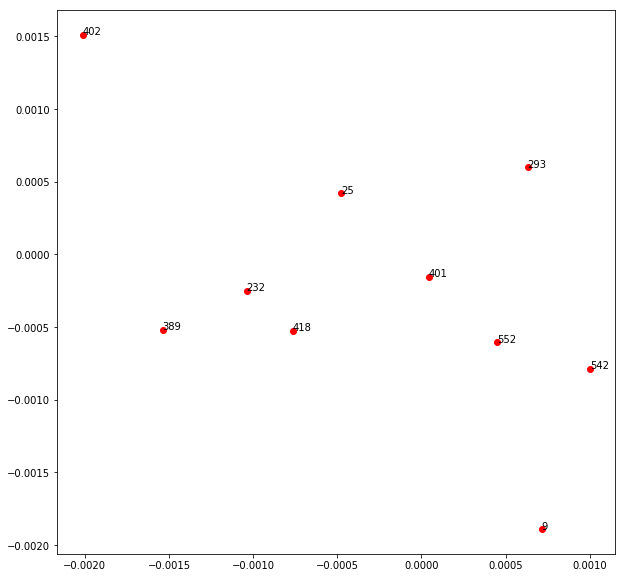

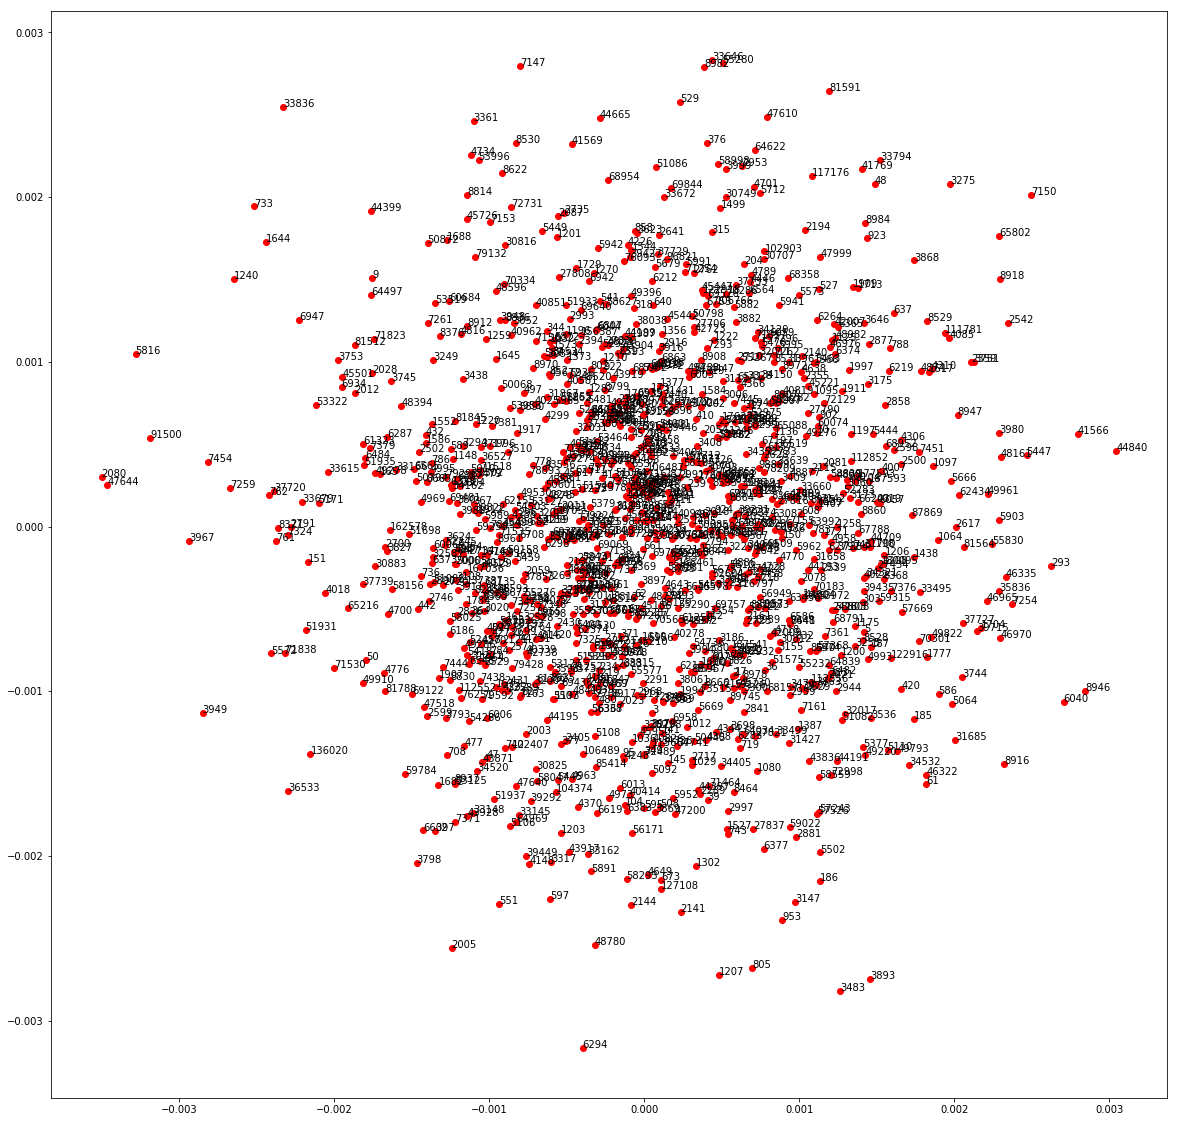

In [14]:
import pylab as plt
import pandas as pd
%matplotlib inline

fig, axes = plt.subplots(figsize=(10,10))

axes.plot(U[0], U[1], 'ro')
for name in U.index:
    axes.text(U[0][name], U[1][name], name)


    
fig, axes = plt.subplots(figsize=(20,20))
axes.plot(V[0], V[1], 'ro')
for ind in V.index:
        axes.text(V[0][ind], V[1][ind], ind)
      

## Is Our Map Enough? Are Our Data Enough?

Is two dimensions really enough to capture the complexity of humans and their artforms? Perhaps we need even more dimensions to capture that complexity. Extending our books analogy further, consider how we should place books that have a historical timeframe as well as some geographical location. Do we really want books from the 2nd World War to sit alongside books from the Roman Empire? Books on the American invasion of Sicily in 1943 are perhaps less related to books about Carthage than those that study the Jewish Revolt from 66-70 (in the Roman Province of Judaea). So books that relate to subjects which are closer in time should be stored together. However, a student of rebellion against empire may also be interested in the relationship between the Jewish Revolt of 66-70 and the Indian Rebellion of 1857, nearly 1800 years later. Whilst the technologies are different, the psychology of the people is shared: a rebellious nation angainst their imperial masters, triggered by misrule with a religious and cultural background. To capture such complexities we would need further dimensions in our latent representation. But are further dimensions justified by the amount of data we have? Can we really understand the facets of a film that only has at most three or four ratings?

## Going Further

If you want to take this model further then you'll need more data. You can use again the MovieLens 100k data but increasing the number of users (for example, for the Steepest Descent Algorithm you can do this by modifying the variable `nUsersInExample` that was set as 10 before).

### Assignment Question 8

Use stochastic gradient descent to make a movie map for the MovieLens 100k data. Plot the map of the movies when you are finished.

*15 marks*

In [16]:
# Code for question 8 here.

import sys
import pods
%matplotlib inline


d = pods.datasets.movielens100k()
Y_100=d['Y']

filmS = d['film_info']

Y_100.rating = Y_100.rating - Y_100.rating.mean()

def objective_gradient(Y, U, V):
    obj = 0.
    for ind, series in Y.iterrows():
        film = series['item']
        user = series['user']
        rating = series['rating']
        prediction = np.dot(U.loc[user], V.loc[film])
        diff = prediction - rating
        obj += diff*diff
    return obj


userX = Y_100.user.unique()
itemX = Y_100.item.unique()
array_u = np.random.normal(size=(len(userX), q))*0.001
array_v = np.random.normal(size=(len(itemX), q))*0.001
U = pd.DataFrame(array_u, index=userX)
V = pd.DataFrame(array_v, index=itemX)



learn_rate = 0.01
counter = 0

for i in range(5):

    for ind, series in Y_100.iterrows():

        film = series['item']
        user = series['user']
        y = series['rating']
    
        u = U.loc[user].values
        v = V.loc[film].values
        
        u = u + learn_rate*v*(y-np.dot(u,v))
        v = v + learn_rate*u*(y-np.dot(u,v))
        
        U.loc[user]=u
        V.loc[film]=v
        counter +=1
        
        if not counter % 100000: 
            obj = objective_gradient(Y_100.loc[Y_100.index[::5000]], U, V)
            print ("Update:", counter, "Objective:", obj) 
            


Update: 100000 Objective: 3674.218307328728
Update: 200000 Objective: 3674.21800603471
Update: 300000 Objective: 3674.2174044530243
Update: 400000 Objective: 3674.215341938914
Update: 500000 Objective: 3674.2058467654992
Update: 600000 Objective: 3674.154390013188
Update: 700000 Objective: 3673.858877076278
Update: 800000 Objective: 3672.022994659463
Update: 900000 Objective: 3661.6287891195684
Update: 1000000 Objective: 3603.38047558981


KeyboardInterrupt: 

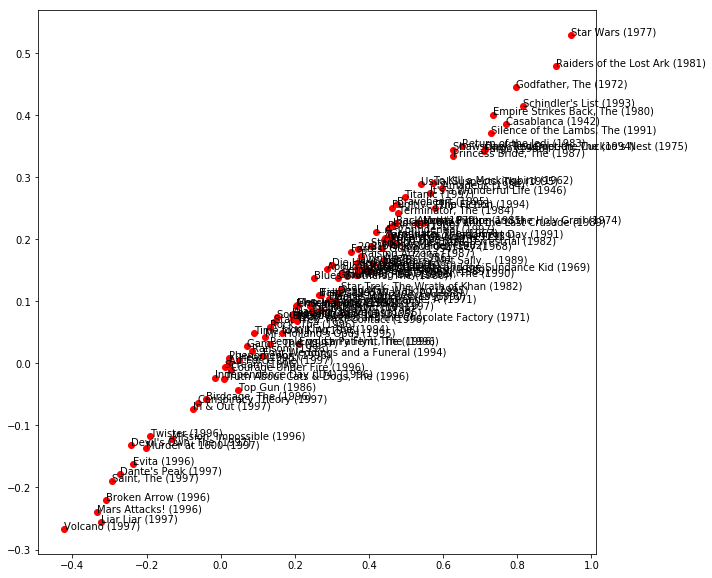

In [18]:

fig, axes = plt.subplots(figsize=(10,10))

for index in V.index:
    if np.sum(Y_100['item']==index)>1500:
        axes.plot(V[0][index], V[1][index], 'ro')
        axes.text(V[0][index], V[1][index], filmS['title'][index])
        